In [1]:
import numpy as np
import sncosmo
from tqdm.notebook import tqdm
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib import cm
sns.set_context('paper')

from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const
from scipy.optimize import minimize
import json

import sys
sys.path.append('../')
from scripts import tde_utils

l_alpha = 1215.67 #angstrom

In [2]:
def d_maglim(z, args):
    try:
        filt, maglim, model = args

        model.set(z=z)
        luminosity_distance = cosmo.luminosity_distance(z)

        filter_abs_mag = model.bandmag(filt, 'ab', 0)
        app_mag = filter_abs_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))

        return np.abs(app_mag - (maglim))
    except:
        return 1000

In [3]:
def get_max_z(model, passband, maglim):

    res = minimize(d_maglim, 
                   args = [passband, maglim, model], 
                   bounds = [[0.01, 40]],
                   x0=7,
                  method = 'L-BFGS-B')
    
    max_z = res.x[0]
    
    band = sncosmo.get_bandpass(passband)
    z_contam = (band.minwave() / l_alpha) - 1
    if max_z > z_contam:
        max_z = z_contam
    return max_z

In [4]:
def get_max_z2(model, passband, maglim):

    
    for z in np.linspace(0., 30, 300):
        model.set(z=z)
        luminosity_distance = cosmo.luminosity_distance(z)

        filter_abs_mag = model.bandmag(passband, 'ab', 0)
        app_mag = filter_abs_mag + 5*np.log10(luminosity_distance/(10 * u.parsec))
        
        if app_mag > maglim:
            return z
        
    return None

In [5]:
def calc_volume(sq_degrees, z):
    
    sphere_area_sterad = 4*np.pi
    sphere_area_degrees = sphere_area_sterad * ((180/np.pi)**2)
    fractional_area = sq_degrees / sphere_area_degrees

    total_volume = cosmo.comoving_volume(z)
    
    return total_volume * fractional_area

In [6]:
roman_filters = ['F062', 'F087', 
                 'F106', 'F129', 
                 'F158', 'F184', 
                 'F213', 'F146']

In [44]:
with open('../survey_master_list.json', 'r') as fp:
    survey_limits = json.load(fp)
    
wide_limits = survey_limits['roman_wide_limits']
deep_limits = survey_limits['roman_deep_limits']
hour_limits = survey_limits['roman_1hour_limits']
minute_limits = survey_limits['roman_1min_limits']
proposal_limits = survey_limits['roman_proposal_limits']

In [8]:
tde_source = tde_utils.BlackBodySource(30000)
tde_model = sncosmo.Model(source=tde_source)

In [13]:
tde_rate = (5e-8 * u.year**(-1) * u.Mpc**(-3))

In [14]:
def get_n_tdes(sq_degs, max_z, min_z=0, z_step=0.05):
    n_tdes = 0
    tde_rate = (5e-8 * u.year**(-1) * u.Mpc**(-3))
    for z in np.arange(min_z, max_z, z_step):
        volume1 = calc_volume(sq_degs, z+z_step)
        volume2 = calc_volume(sq_degs, z)
        volume = volume1 - volume2
        local_tde_rate = tde_rate / (1 + z)
        n_local_tdes = local_tde_rate * volume
        n_tdes += n_local_tdes
    return n_tdes

In [28]:
max_zs = {}
max_zs['Survey Depth'] = ['One minute limits', 'One hour limits', 'HLTDS Wide Limits', 'HLTDS Deep Limits', 'Roman Proposal Limits']

for filt in tqdm(roman_filters):
    mags = []
    for depth in [minute_limits, hour_limits, wide_limits, deep_limits, proposal_limits]:
        limit = depth[filt]
        max_z = get_max_z(tde_model, filt, limit)
        if filt =='F213':
            print('F213', limit, max_z)
        band = sncosmo.get_bandpass(filt)
        z_contam = (band.minwave() / l_alpha) - 1
        if max_z > z_contam:
            print('repacing max z {} in {} with lyman-corrected: {} for depth {}'.format(max_z, filt, z_contam, limit))
            max_z = z_contam
        mags.append(max_z)
    max_zs[filt] = mags

  0%|          | 0/8 [00:00<?, ?it/s]

F213 23.7 0.341233609965
F213 26.2 2.67778318408
F213 0 0.01
F213 0 0.01
F213 26.7 6.19477339712


In [29]:
print('MAX Z:\n-------')
print(tabulate(max_zs, headers='keys', floatfmt='.3f'))

MAX Z:
-------
Survey Depth             F062    F087    F106    F129    F158    F184    F213    F146
---------------------  ------  ------  ------  ------  ------  ------  ------  ------
One minute limits       2.784   2.744   2.371   1.670   1.130   0.623   0.341   3.914
One hour limits         2.784   5.005   6.321   7.966   9.940  11.805   2.678   6.321
HLTDS Wide Limits       2.784   3.856   3.375   2.511   0.010   0.010   0.010   0.010
HLTDS Deep Limits       0.010   0.010   6.321   7.079   6.449   7.168   0.010   0.010
Roman Proposal Limits   2.784   3.856   3.375   2.511   6.449   7.168   6.195   2.329


TDEs/deg^2/yr
20
F184 7.16807925195
F158 6.44931607855
F213 6.19477339712
F087 3.85575655568
F106 3.37474538778
F062 2.78392162347
F129 2.51069292149


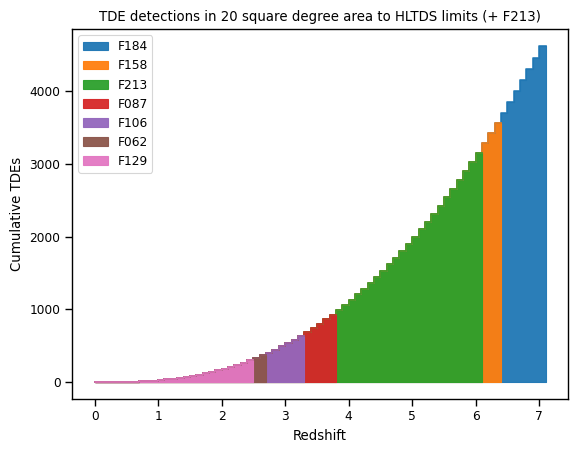

In [170]:
print('TDEs/deg^2/yr')
for sq_degs in [20]:
    print(sq_degs)
    for i, filt in enumerate(['F184', "F158", 'F213', "F087", 'F106', "F062", "F129"]):
        nums = []
        for depth in [proposal_limits]:
            limit = depth[filt]
            max_z = get_max_z(tde_model, filt, limit)
            print(filt, max_z)
            zbins = [0]
            counts = []
            z_step = 0.1
            for z in np.arange(0+z_step, max_z+z_step, z_step):
                volume1 = calc_volume(sq_degs, z)
                volume2 = calc_volume(sq_degs, z-z_step)
                volume = volume1 - volume2
                local_tde_rate = tde_rate * (1 + z)**(7/2) / (1 + z)
                num = local_tde_rate * volume
                zbins.append(z)
                counts.append(num.value)
        plt.plot(zbins[:-1], np.cumsum(counts), drawstyle='steps', 
                 c = 'C{}'.format(i), alpha= 0.95)
        plt.fill_between(zbins[:-1], np.zeros_like(zbins[:-1]), np.cumsum(counts), 
                         color = 'C{}'.format(i), step='pre', alpha = 0.95, label = filt)
    plt.legend()
    plt.title('TDE detections in 20 square degree area to HLTDS limits (+ F213)')
    plt.xlabel('Redshift')
    plt.ylabel('Cumulative TDEs')
    plt.savefig('../figures/tde_cdf_roman_norman.pdf', dpi = 300, bbox_inches='tight')
    plt.show()

Text(0, 0.5, 'Number of TDEs Observed')

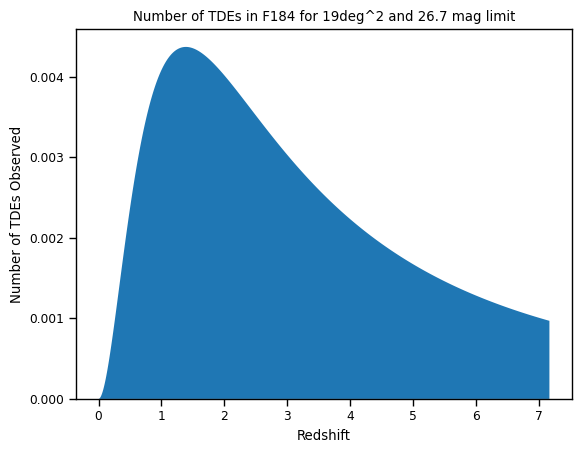

In [39]:
plt.stairs(counts, zbins, fill=True)
plt.title('Number of TDEs in F184 for 19deg^2 and 26.7 mag limit')
plt.xlabel('Redshift')
plt.ylabel('Number of TDEs Observed')
#plt.savefig('../figures/z_hist.pdf', bbox_inches='tight')

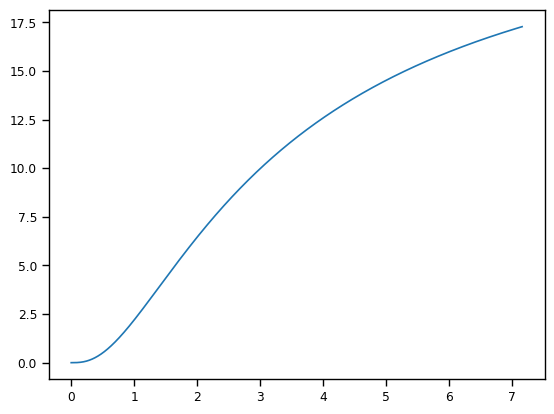

In [170]:
plt.plot(zbins[:-1], np.cumsum(counts))

In [160]:
np.cumsum(counts)[-1]

17.279558841931241

In [120]:
print('TDEs/deg^2/yr')
for sq_degs in [19]:
    print(sq_degs)
    for filt in ['F184']:
        nums = []
        for depth in [minute_limits, hour_limits, wide_limits, deep_limits]:
            limit = depth[filt]
            max_z = get_max_z(tde_model, filt, limit)
            zbins = [0]
            counts = []
            z_step = 0.5
            for z in np.arange(0+z_step, max_z+z_step, z_step):
                volume1 = calc_volume(sq_degs, z)
                volume2 = calc_volume(sq_degs, z-z_step)
                volume = volume1 - volume2
                local_tde_rate = tde_rate / (1 + z)
                num = local_tde_rate * volume
                zbins.append(z)
                counts.append(num.value)

TDEs/deg^2/yr
19


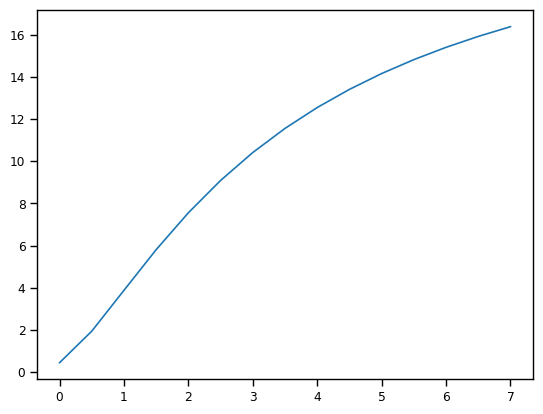

In [124]:
plt.plot(zbins[:-1], np.cumsum(counts))

In [76]:
print('TDEs/deg^2/yr')
for sq_degs in [1, 4.2, 19]:
    print(sq_degs)
    numbers = {}
    numbers['Survey Depth'] = ['One minute (1 deg^2)', 'One hour (1 deg^2)', 'HLTDS Wide (19 deg^2)', 'HLTDS Deep (4.2 deg^2)', 'Proposal']
    for filt in roman_filters:
        nums = []
        for depth in [minute_limits, hour_limits, wide_limits, deep_limits, proposal_limits]:
            limit = depth[filt]
            max_z = get_max_z(tde_model, filt, limit)
            num = get_n_tdes(sq_degs, max_z)
            nums.append(num.value)
        numbers[filt] = nums
    
    print(tabulate(numbers, headers='keys', floatfmt='.2f'))

TDEs/deg^2/yr
1
Survey Depth              F062    F087    F106    F129    F158    F184    F213    F146
----------------------  ------  ------  ------  ------  ------  ------  ------  ------
One minute (1 deg^2)      0.50    0.49    0.42    0.28    0.15    0.05    0.01    0.66
One hour (1 deg^2)        0.50    0.77    0.87    0.96    1.02    1.07    0.48    0.87
HLTDS Wide (19 deg^2)     0.50    0.66    0.59    0.45    0.00    0.00    0.00    0.00
HLTDS Deep (4.2 deg^2)    0.00    0.00    0.87    0.91    0.88    0.92    0.00    0.00
Proposal                  0.50    0.66    0.87    0.91    0.88    1.08    1.12    0.85
4.2
Survey Depth              F062    F087    F106    F129    F158    F184    F213    F146
----------------------  ------  ------  ------  ------  ------  ------  ------  ------
One minute (1 deg^2)      2.09    2.05    1.78    1.16    0.63    0.20    0.05    2.78
One hour (1 deg^2)        2.09    3.25    3.66    4.01    4.30    4.50    2.01    3.66
HLTDS Wide (19 deg^2)  

In [77]:
print('TDEs with z>5/deg^2/yr')
for sq_degs in [1, 4.2, 19]:
    numbers = {}
    numbers['Survey Depth'] = ['One minute (1 deg^2)', 'One hour (1 deg^2)', 'HLTDS Wide (19 deg^2)', 'HLTDS Deep (4.2 deg^2)', 'Proposal']

    for filt in roman_filters:
        nums = []
        for depth in [minute_limits, hour_limits, wide_limits, deep_limits, proposal_limits]:
            limit = depth[filt]
            max_z = get_max_z(tde_model, filt, limit)
            num = get_n_tdes(sq_degs, max_z, min_z = 5)
            if hasattr(num, 'value'):
                nums.append(num.value)
            else:
                nums.append(num)
        numbers[filt] = nums
    
    print(tabulate(numbers, headers='keys', floatfmt=".2f"))

TDEs with z>5/deg^2/yr
Survey Depth              F062    F087    F106    F129    F158    F184    F213    F146
----------------------  ------  ------  ------  ------  ------  ------  ------  ------
One minute (1 deg^2)         0    0.00    0.00    0.00    0.00    0.00    0.00    0.00
One hour (1 deg^2)           0    0.00    0.10    0.19    0.25    0.30    0.00    0.10
HLTDS Wide (19 deg^2)        0    0.00    0.00    0.00    0.00    0.00    0.00    0.00
HLTDS Deep (4.2 deg^2)       0    0.00    0.10    0.14    0.11    0.15    0.00    0.00
Proposal                     0    0.00    0.10    0.14    0.11    0.31    0.35    0.08
Survey Depth              F062    F087    F106    F129    F158    F184    F213    F146
----------------------  ------  ------  ------  ------  ------  ------  ------  ------
One minute (1 deg^2)         0    0.00    0.00    0.00    0.00    0.00    0.00    0.00
One hour (1 deg^2)           0    0.02    0.42    0.78    1.07    1.26    0.00    0.42
HLTDS Wide (19 deg^2

In [62]:
10/0.3

33.333333333333336

In [69]:
max_z_list = []
number_list = []
depths = np.arange(23, 29)
for limit in depths:
    nums = []
    zs = []
    for filt in roman_filters:
        max_z = get_max_z(tde_model, filt, limit)
        num = get_n_tdes(1, max_z)
        nums.append(num.value)
        zs.append(max_z)
    number_list.append(nums)
    max_z_list.append(zs)

In [70]:
number_list = np.array(number_list)
max_z_list = np.array(max_z_list)

/var/folders/9_/177p01wj5yq421833hg4p2yc0000gn/T/ipykernel_25016/1188750379.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='rainbow'), label = 'maximum z')


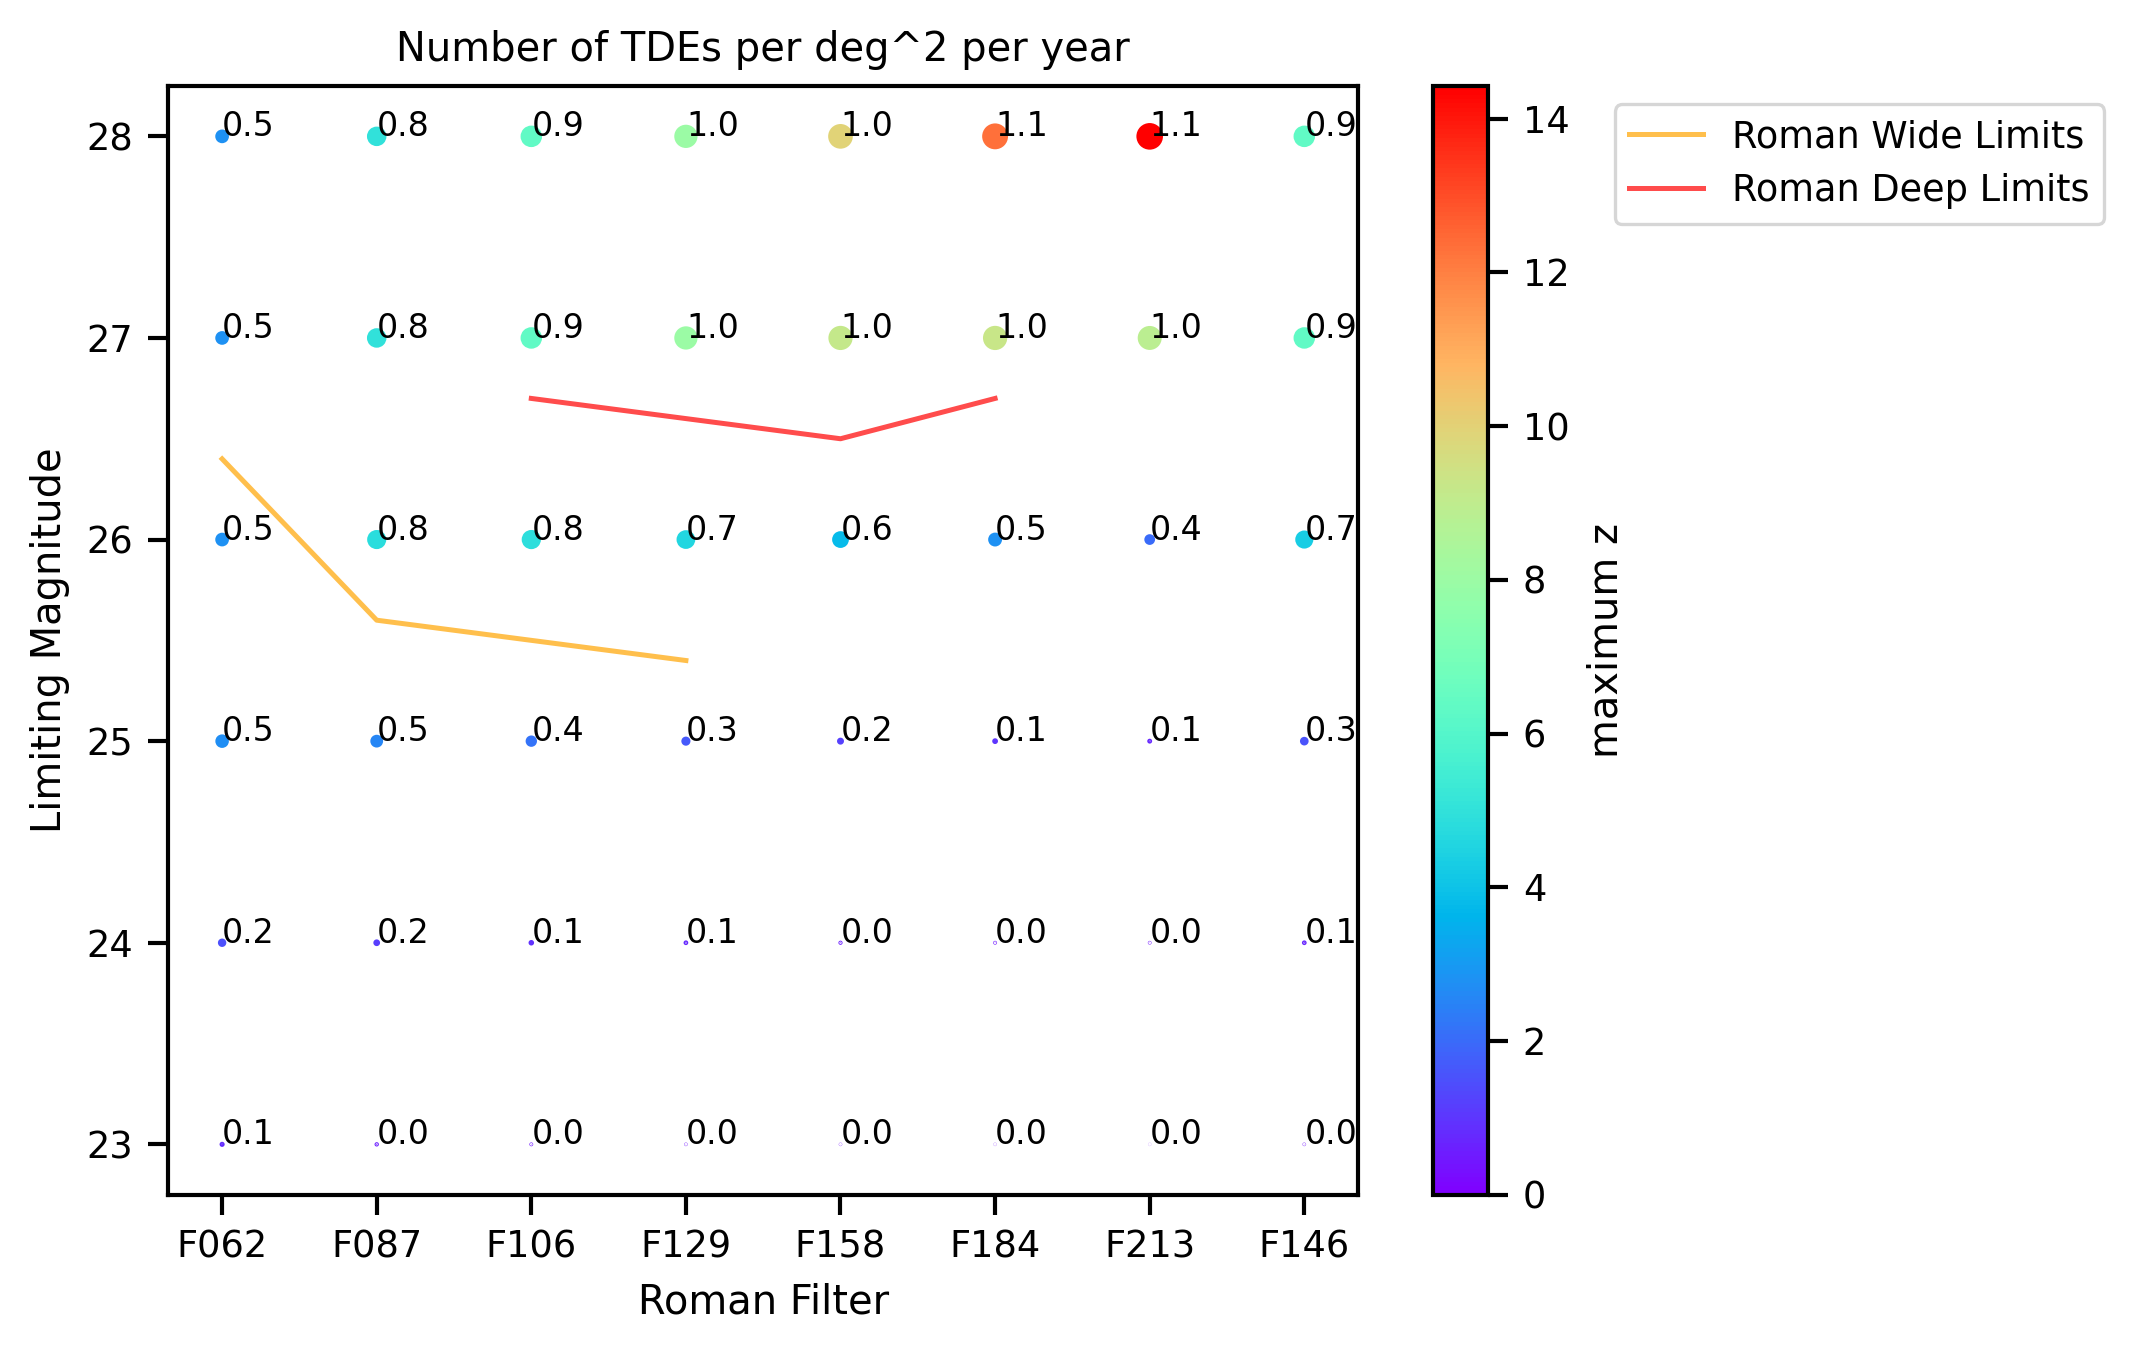

In [71]:
plt.figure(dpi = 300)
norm = Normalize(0, np.max(max_z_list))
for i, depth in enumerate(depths):
    plt.scatter(roman_filters, [depth]*len(roman_filters), 
                s = (5*number_list[i])**2, color=cm.rainbow(norm(max_z_list[i])))
    for j in range(len(roman_filters)):
        plt.text(roman_filters[j], depth, '{:.1f}'.format(number_list[i][j]), size = 'small')

ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.plot(list(wide_limits.keys())[:4], list(wide_limits.values())[:4], 
         c = 'orange', alpha = 0.7, zorder = -1, label = 'Roman Wide Limits')
plt.plot(list(deep_limits.keys())[2:6], list(deep_limits.values())[2:6], 
         c = 'red', alpha = 0.7, zorder = -1, label = 'Roman Deep Limits')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='rainbow'), label = 'maximum z')
plt.xlabel('Roman Filter')
plt.ylabel('Limiting Magnitude')
plt.title('Number of TDEs per deg^2 per year')
ax.legend(bbox_to_anchor=(1.2, 1.))
plt.savefig('../figures/mag_filter_z_num.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [72]:
wide_limits, deep_limits

({'F062': 26.4,
  'F087': 25.6,
  'F106': 25.5,
  'F129': 25.4,
  'F158': 0,
  'F184': 0,
  'F213': 0,
  'F146': 0},
 {'F062': 0,
  'F087': 0,
  'F106': 26.7,
  'F129': 26.6,
  'F158': 26.5,
  'F184': 26.7,
  'F213': 0,
  'F146': 0})

# Add LSST

In [73]:
lsst_30s_limits = survey_limits['lsst_30s_limits']
lsst_ddf_limits = survey_limits['lsst_ddf_limits']

In [74]:
# LSST WFD 18,000 deg^2
# LSST DDF 38 deg^2

In [75]:
lsst_filters = ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']

In [76]:
max_z_list = []
number_list = []
depths = np.arange(23, 29)
filters_to_use = lsst_filters + roman_filters
for limit in depths:
    nums = []
    zs = []
    for filt in filters_to_use:
        max_z = get_max_z(tde_model, filt, limit)
        num = get_n_tdes(1, max_z)
        nums.append(num.value)
        zs.append(max_z)
    number_list.append(nums)
    max_z_list.append(zs)

number_list = np.array(number_list)
max_z_list = np.array(max_z_list)

/var/folders/9_/177p01wj5yq421833hg4p2yc0000gn/T/ipykernel_25016/569595488.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='rainbow'), label = 'maximum z')


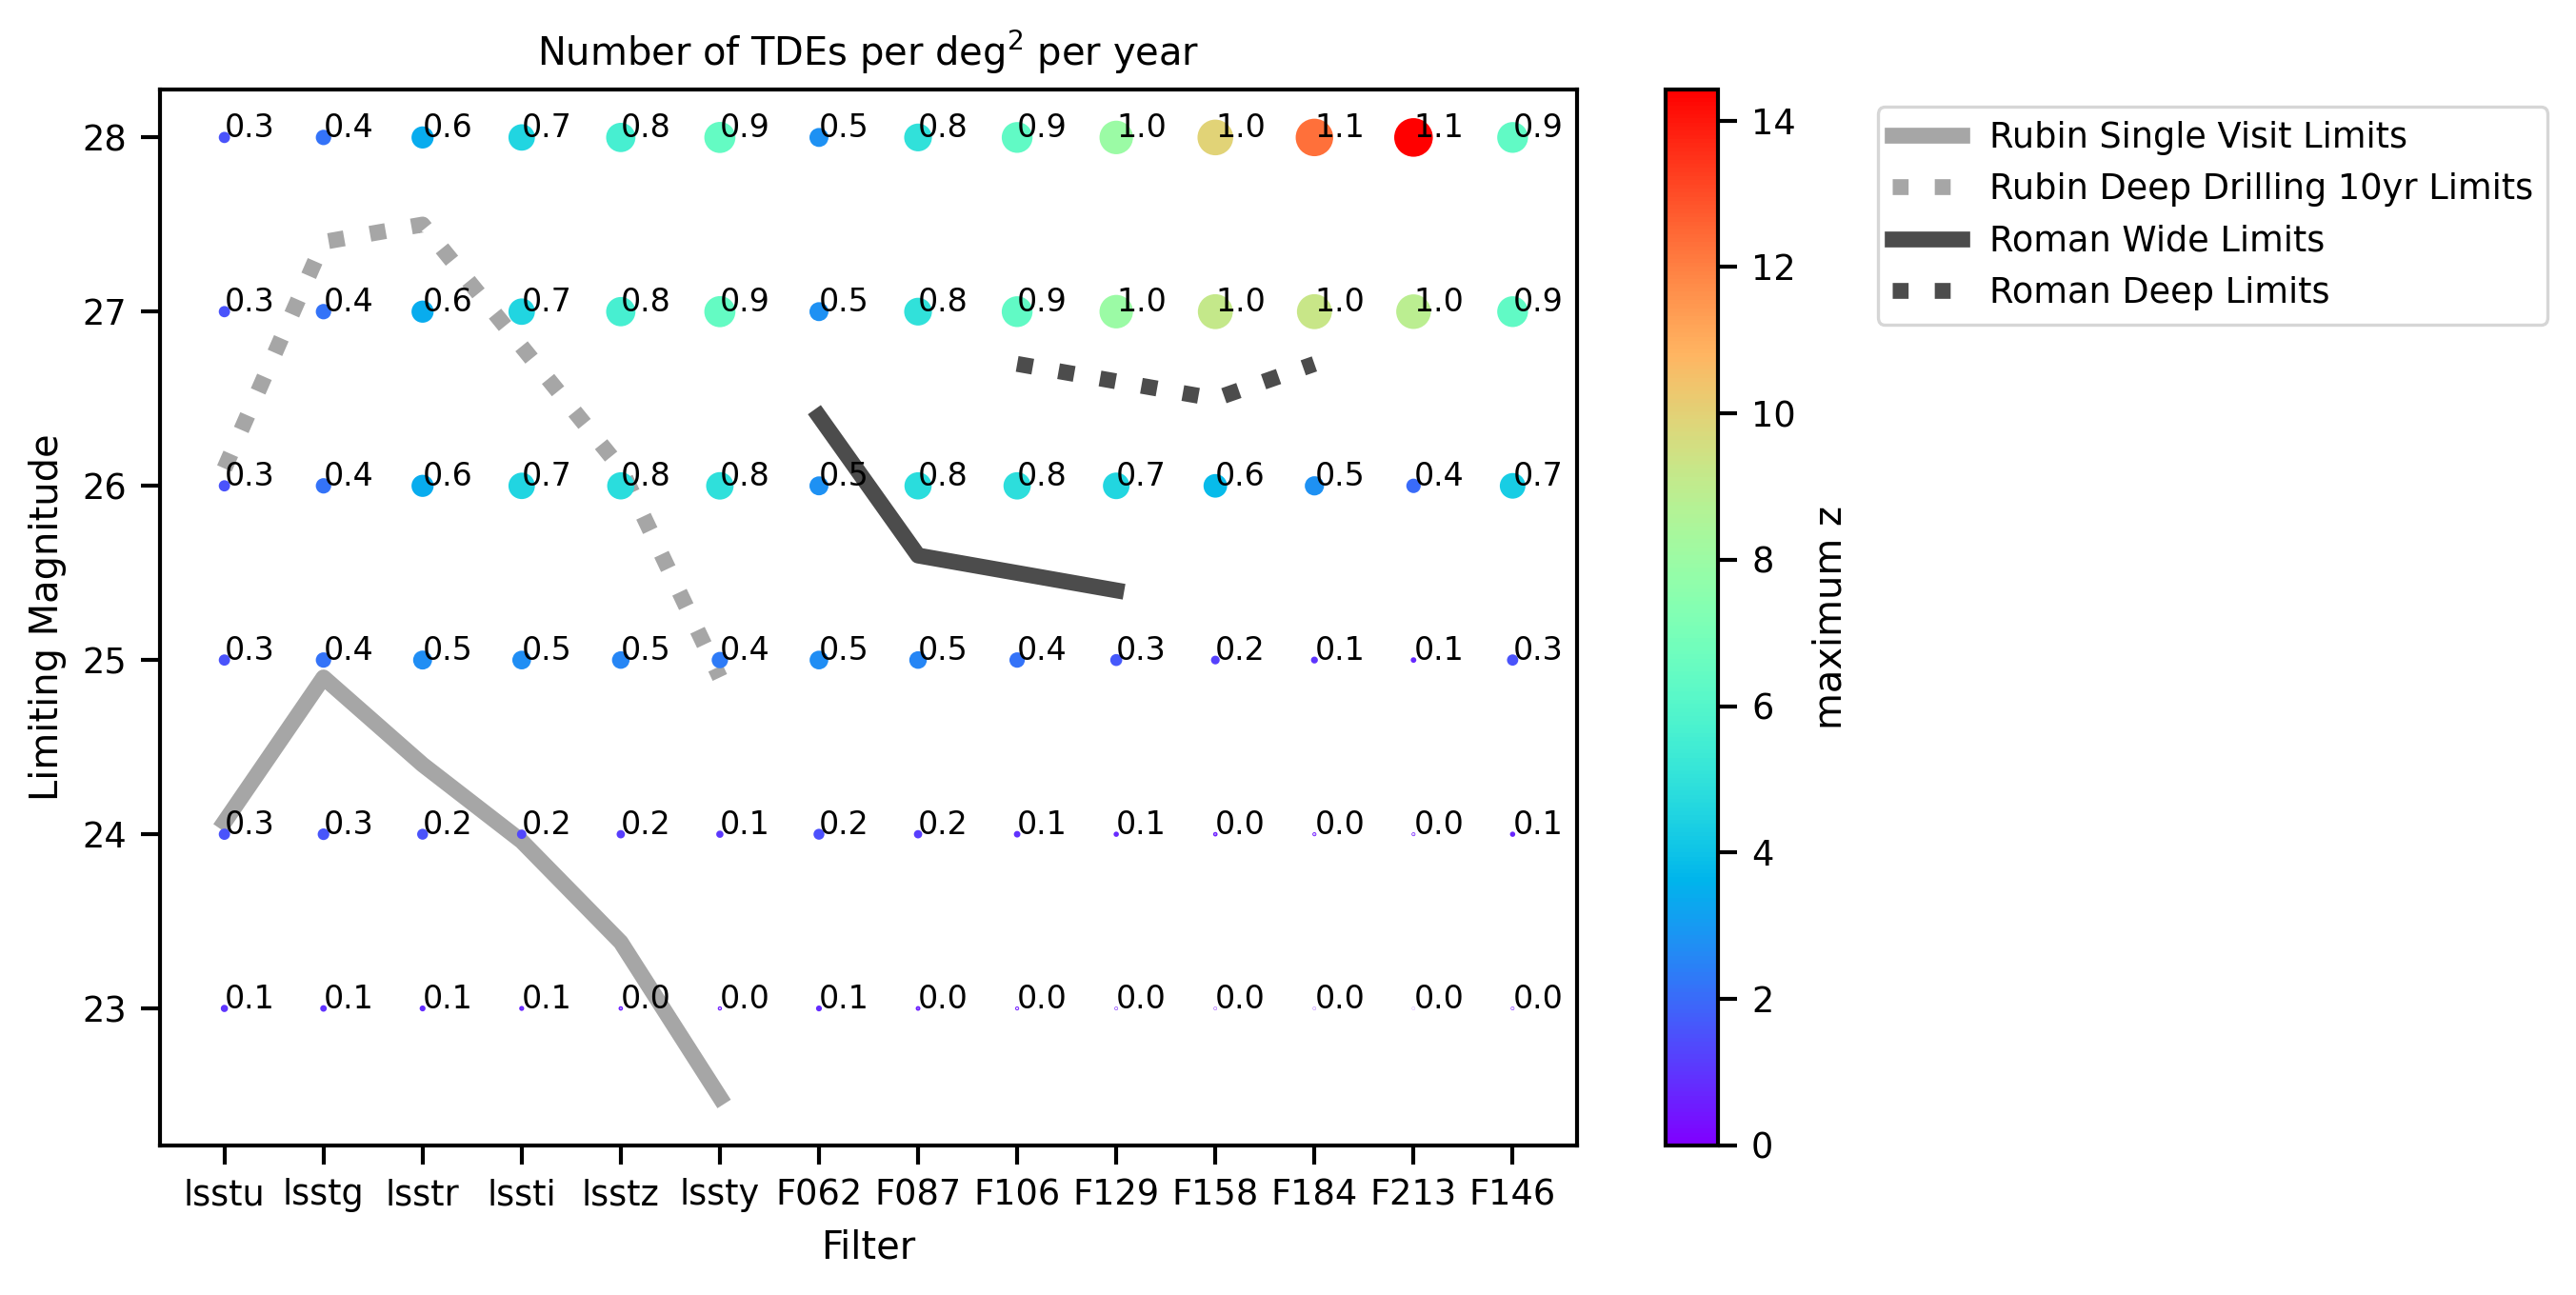

In [77]:
plt.figure(dpi = 300, figsize = [8, 4.8])
norm = Normalize(0, np.max(max_z_list))
for i, depth in enumerate(depths):
    plt.scatter(filters_to_use, [depth]*len(filters_to_use), 
                s = (8*number_list[i])**2, color=cm.rainbow(norm(max_z_list[i])))
    
    for j in range(len(filters_to_use)):
        plt.text(filters_to_use[j], depth, '{:.1f}'.format(number_list[i][j]), size = 'small')

ax = plt.gca()
ymin, ymax = ax.get_ylim()

lw = 4

plt.plot(lsst_filters, list(lsst_30s_limits.values()), 
         c = 'grey', alpha = 0.7, zorder = -1, 
         label = 'Rubin Single Visit Limits', lw = lw)
plt.plot(list(lsst_ddf_limits.keys()), list(lsst_ddf_limits.values()), 
         c = 'grey', ls = ':', alpha = 0.7, zorder = -1, 
         label = 'Rubin Deep Drilling 10yr Limits', lw = lw)

plt.plot(list(wide_limits.keys())[:4], list(wide_limits.values())[:4], 
         c = 'k', alpha = 0.7, zorder = -1, label = 'Roman Wide Limits', lw = lw)
plt.plot(list(deep_limits.keys())[2:6], list(deep_limits.values())[2:6], 
         c = 'k', ls = ':', alpha = 0.7, zorder = -1, label = 'Roman Deep Limits', lw = lw)


plt.colorbar(cm.ScalarMappable(norm=norm, cmap='rainbow'), label = 'maximum z')

plt.xlabel('Filter')
plt.ylabel('Limiting Magnitude')
plt.title('Number of TDEs per deg$^2$ per year')
ax.legend(bbox_to_anchor=(1.2, 1.))
plt.savefig('../figures/lsst_mag_filter_z_num.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [34]:
LSST WFD 18,000 deg^2
# LSST DDF 38 deg^2

SyntaxError: invalid syntax (4149276925.py, line 1)

In [157]:
color_dict = dict(zip(lsst_filters, ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']))

lsstg 2.18013934703
lsstr 1.95523911988
lsstu 1.55414709584
lssti 1.299919151
lsstz 0.76262161799
lssty 0.397649573261


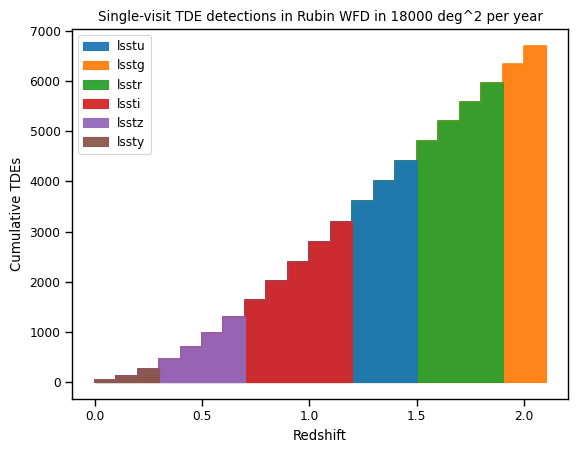

In [165]:
sq_degs = 18000
depth = lsst_30s_limits
handles = {}
for i, filt in enumerate(['lsstg', 'lsstr', 'lsstu', 'lssti', 'lsstz', 'lssty']):
    nums = []
    limit = depth[filt]
    max_z = get_max_z(tde_model, filt, limit)
    print(filt, max_z)
    zbins = [0]
    counts = []
    z_step = 0.1
    for z in np.arange(0+z_step, max_z+z_step, z_step):
        volume1 = calc_volume(sq_degs, z)
        volume2 = calc_volume(sq_degs, z-z_step)
        volume = volume1 - volume2
        local_tde_rate = tde_rate / (1 + z)
        num = local_tde_rate * volume
        zbins.append(z)
        counts.append(num.value)
    plt.plot(zbins[:-1], np.cumsum(counts), drawstyle='steps', 
             color = color_dict[filt], alpha= 0.95)
    f = plt.fill_between(zbins[:-1], np.zeros_like(zbins[:-1]), np.cumsum(counts), 
                     color = color_dict[filt], step='pre', alpha = 0.95, label = filt)
    handles[filt] = f
plt.legend([handles[f] for f in lsst_filters], lsst_filters)
plt.title('Single-visit TDE detections in Rubin WFD in 18000 deg^2 per year')
plt.xlabel('Redshift')
plt.ylabel('Cumulative TDEs')
plt.savefig('../figures/tde_cdf_rubin_wfd.pdf', dpi = 300, bbox_inches='tight')
plt.show()

lsstz 5.07784887601
lssti 4.56071960318
lsstr 3.41731719957
lsstg 2.18013934703
lssty 2.15195148793
lsstu 1.55414709584


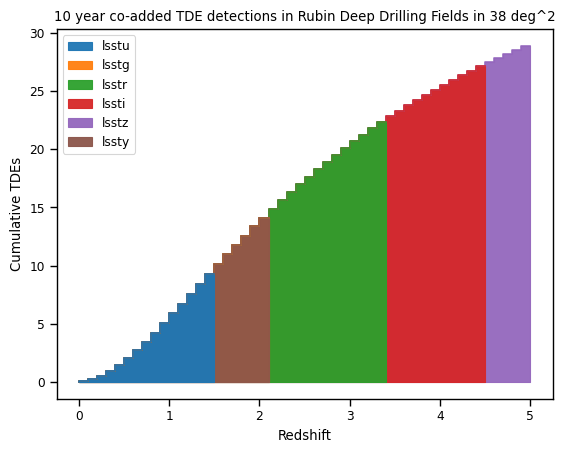

In [166]:
sq_degs = 38
depth = lsst_ddf_limits
handles = {}
for i, filt in enumerate(['lsstz', 'lssti', 'lsstr', 'lsstg', 'lssty', 'lsstu']):
    nums = []
    limit = depth[filt]
    max_z = get_max_z(tde_model, filt, limit)
    print(filt, max_z)
    zbins = [0]
    counts = []
    z_step = 0.1
    for z in np.arange(0+z_step, max_z+z_step, z_step):
        volume1 = calc_volume(sq_degs, z)
        volume2 = calc_volume(sq_degs, z-z_step)
        volume = volume1 - volume2
        local_tde_rate = tde_rate / (1 + z)
        num = local_tde_rate * volume
        zbins.append(z)
        counts.append(num.value)
    plt.plot(zbins[:-1], np.cumsum(counts), drawstyle='steps', 
             color = color_dict[filt], alpha= 0.95)
    f = plt.fill_between(zbins[:-1], np.zeros_like(zbins[:-1]), np.cumsum(counts), 
                     color = color_dict[filt], step='pre', alpha = 0.95, label = filt)
    handles[filt] = f
plt.legend([handles[f] for f in lsst_filters], lsst_filters)
plt.title('10 year co-added TDE detections in Rubin Deep Drilling Fields in 38 deg^2')
plt.xlabel('Redshift')
plt.ylabel('Cumulative TDEs')
plt.savefig('../figures/tde_cdf_rubin_ddf.pdf', dpi = 300, bbox_inches='tight')
plt.show()

# JWST

In [45]:
jwst_limits = survey_limits['jwst_nircam_10000s_limits']

In [46]:
jwst_filters = list(jwst_limits.keys())

In [78]:
max_z_list = []
number_list = []
depths = np.arange(24, 30)
filters_to_use = jwst_filters #+ roman_filters
for limit in depths:
    nums = []
    zs = []
    for filt in filters_to_use:
        max_z = get_max_z(tde_model, filt, limit)
        num = get_n_tdes(1, max_z)
        nums.append(num.value)
        zs.append(max_z)
    number_list.append(nums)
    max_z_list.append(zs)

number_list = np.array(number_list)
max_z_list = np.array(max_z_list)

/var/folders/9_/177p01wj5yq421833hg4p2yc0000gn/T/ipykernel_25016/2987642657.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='rainbow'), label = 'maximum z')


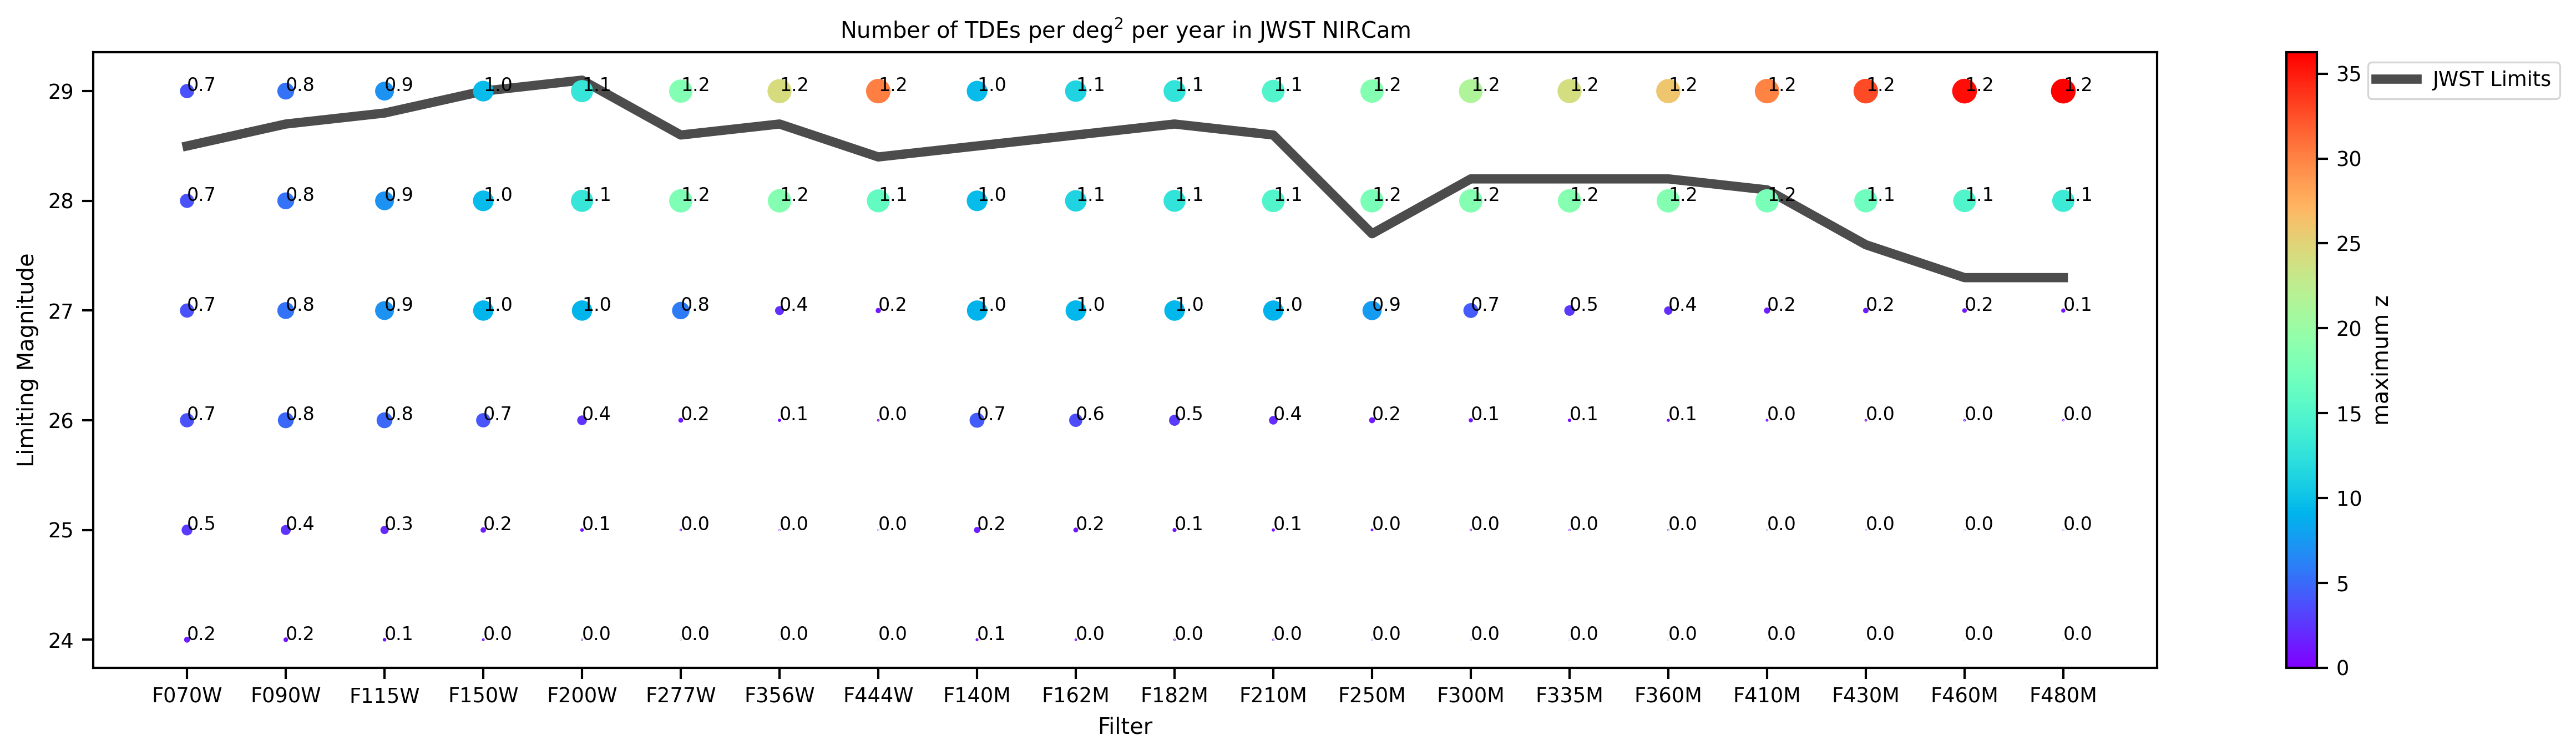

In [79]:
plt.figure(dpi = 300, figsize = [20, 4.8])
norm = Normalize(0, np.max(max_z_list))
for i, depth in enumerate(depths):
    plt.scatter(filters_to_use, [depth]*len(filters_to_use), 
                s = (8*number_list[i])**2, color=cm.rainbow(norm(max_z_list[i])))
    
    for j in range(len(filters_to_use)):
        plt.text(filters_to_use[j], depth, '{:.1f}'.format(number_list[i][j]), size = 'small')

ax = plt.gca()
ymin, ymax = ax.get_ylim()

# lw = 4

# plt.plot(lsst_filters, list(lsst_30s_limits.values()), 
#          c = 'grey', alpha = 0.7, zorder = -1, 
#          label = 'Rubin Single Visit Limits', lw = lw)
# plt.plot(list(lsst_ddf_limits.keys()), list(lsst_ddf_limits.values()), 
#          c = 'grey', ls = ':', alpha = 0.7, zorder = -1, 
#          label = 'Rubin Deep Drilling 10yr Limits', lw = lw)

plt.plot(list(jwst_limits.keys()), list(jwst_limits.values()), 
         c = 'k', alpha = 0.7, zorder = -1, label = 'JWST Limits', lw = lw)
# plt.plot(list(deep_limits.keys())[2:6], list(deep_limits.values())[2:6], 
#          c = 'k', ls = ':', alpha = 0.7, zorder = -1, label = 'Roman Deep Limits', lw = lw)


plt.colorbar(cm.ScalarMappable(norm=norm, cmap='rainbow'), label = 'maximum z')

plt.xlabel('Filter')
plt.ylabel('Limiting Magnitude')
plt.title('Number of TDEs per deg$^2$ per year in JWST NIRCam')
ax.legend(bbox_to_anchor=(1.2, 1.))
plt.savefig('../figures/jwst_mag_filter_z_num.pdf', dpi = 300, bbox_inches='tight')
plt.show()

F070W 3.9520017768
F090W 5.47379634276
F115W 7.18478698989
F150W 9.60320646228
F200W 13.01696184
F277W 18.3827272204
F356W 24.2535638784
F444W 24.94321134
F140M 9.57852871256
F162M 11.2895193597
F182M 12.6550215108
F210M 14.941826318
F250M 14.935711208
F300M 20.6189363688
F335M 21.2539654228
F360M 21.5192466063
F410M 19.6720346447
F430M 3.85832266586
F460M 1.54659040825
F480M 1.42278309372


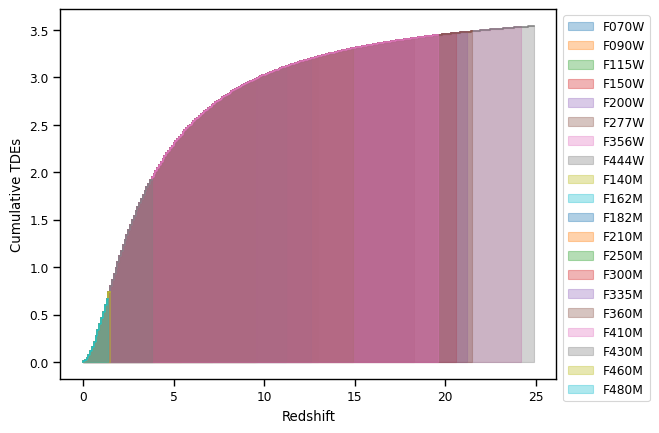

In [81]:
sq_degs = 3
depth = jwst_limits
handles = {}
for i, filt in enumerate(jwst_limits.keys()):
    nums = []
    limit = depth[filt]
    max_z = get_max_z(tde_model, filt, limit)
    print(filt, max_z)
    zbins = [0]
    counts = []
    z_step = 0.1
    for z in np.arange(0+z_step, max_z+z_step, z_step):
        volume1 = calc_volume(sq_degs, z)
        volume2 = calc_volume(sq_degs, z-z_step)
        volume = volume1 - volume2
        local_tde_rate = tde_rate / (1 + z)
        num = local_tde_rate * volume
        zbins.append(z)
        counts.append(num.value)
    plt.plot(zbins[:-1], np.cumsum(counts), drawstyle='steps', 
             color = 'C{}'.format(i), alpha= 0.95)
    f = plt.fill_between(zbins[:-1], np.zeros_like(zbins[:-1]), np.cumsum(counts), 
                     color = 'C{}'.format(i), step='pre', alpha = 0.35, label = filt)
    handles[filt] = f
plt.legend([handles[f] for f in jwst_limits.keys()], jwst_limits.keys(), bbox_to_anchor=(1.2, 1.))
#plt.title('Single-visit TDE detections in Rubin WFD in 18000 deg^2 per year')
plt.xlabel('Redshift')
plt.ylabel('Cumulative TDEs')
plt.savefig('../figures/tde_cdf_jwst.pdf', dpi = 300, bbox_inches='tight')
plt.show()